In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, models, plot
from pathlib import Path
from skimage import exposure
import re

2022-07-19 16:33:07,227 [INFO] WRITING LOG OUTPUT TO C:\Users\teaguest\.cellpose\run.log


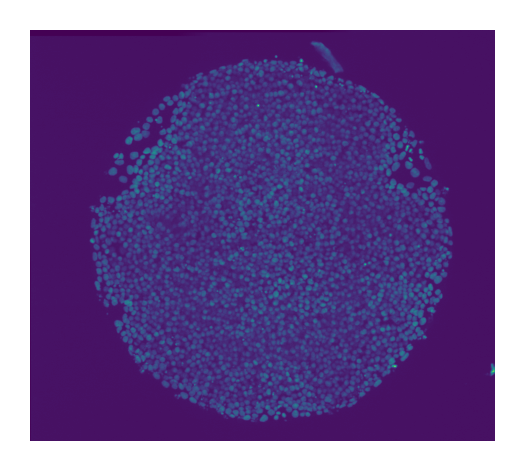

nzslices = 9


In [2]:
# get a list of files to segment
dataDir = Path(os.getcwd())

nucChannel = 0 #nuclear channel
files = []
for filename in Path(dataDir).rglob("stitched_p*_w%.4d*.tif" % nucChannel):
    filepath = os.path.split(filename)[0]
    if filepath == str(dataDir):
        files.append(filename)
    #print(filename)

# view 1 image
img = io.imread(files[0])
nzslices = img.shape[0] #number of z slices
plt.figure(figsize=(2,2))
plt.imshow(img[1,:,:])
plt.axis('off')
plt.show()
print('nzslices =', nzslices)

In [3]:
files

[WindowsPath('Y:/Seth/220712_Smad4GFP_BMP_IWP2_MP_live/fixed_round1/stitched_p0000_w0000_t0000.tif'),
 WindowsPath('Y:/Seth/220712_Smad4GFP_BMP_IWP2_MP_live/fixed_round1/stitched_p0001_w0000_t0000.tif'),
 WindowsPath('Y:/Seth/220712_Smad4GFP_BMP_IWP2_MP_live/fixed_round1/stitched_p0002_w0000_t0000.tif'),
 WindowsPath('Y:/Seth/220712_Smad4GFP_BMP_IWP2_MP_live/fixed_round1/stitched_p0003_w0000_t0000.tif'),
 WindowsPath('Y:/Seth/220712_Smad4GFP_BMP_IWP2_MP_live/fixed_round1/stitched_p0004_w0000_t0000.tif'),
 WindowsPath('Y:/Seth/220712_Smad4GFP_BMP_IWP2_MP_live/fixed_round1/stitched_p0005_w0000_t0000.tif'),
 WindowsPath('Y:/Seth/220712_Smad4GFP_BMP_IWP2_MP_live/fixed_round1/stitched_p0006_w0000_t0000.tif'),
 WindowsPath('Y:/Seth/220712_Smad4GFP_BMP_IWP2_MP_live/fixed_round1/stitched_p0007_w0000_t0000.tif'),
 WindowsPath('Y:/Seth/220712_Smad4GFP_BMP_IWP2_MP_live/fixed_round1/stitched_p0008_w0000_t0000.tif'),
 WindowsPath('Y:/Seth/220712_Smad4GFP_BMP_IWP2_MP_live/fixed_round1/stitched_p0009

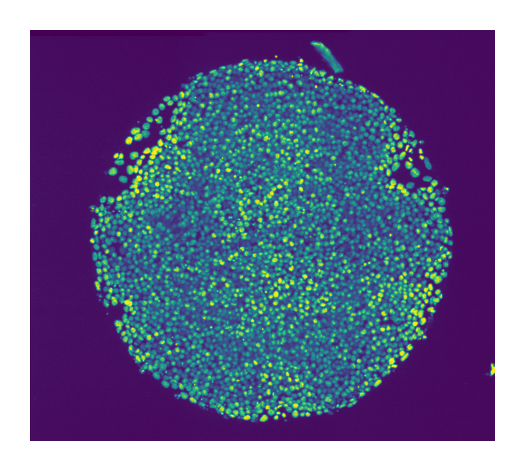

In [4]:
#display image with rescaled + saturated intensity
from skimage import exposure
im = img[1,:,:]
p1, p99 = np.percentile(im, (1, 99))
J = exposure.rescale_intensity(im, in_range=(p1, p99))

plt.figure(figsize=(2,2))
plt.imshow(J)
plt.axis('off')
plt.show()

In [5]:
#run the model once
#if you set diameter=None in the call to model.eval, it will run the model once to estimate the size of nuclei and run again
#to do actual segmentation but this is slow and works less well on the micropattern than on sparser disordered cells
#I generally estimate in Fiji instead; for 40x, nuclear diameter generally ranges from ~25-70 pixels
model = models.Cellpose(gpu=True, model_type='nuclei')
chan = [0,0] #use chan = [0,0] for nuclear segmentation only
im = img[1,:,:]
p1, p99 = np.percentile(im, (1, 99))
J = exposure.rescale_intensity(im, in_range=(p1, p99))
masks, flows, styles, diams = model.eval(J, diameter=20, channels=chan, net_avg=True)

2022-07-19 16:33:29,874 [INFO] ** TORCH CUDA version installed and working. **
2022-07-19 16:33:29,874 [INFO] >>>> using GPU
2022-07-19 16:33:30,030 [INFO] ~~~ FINDING MASKS ~~~


C:\Users\teaguest\Anaconda3\envs\cellpose\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


2022-07-19 16:33:35,272 [INFO] >>>> TOTAL TIME 5.24 sec


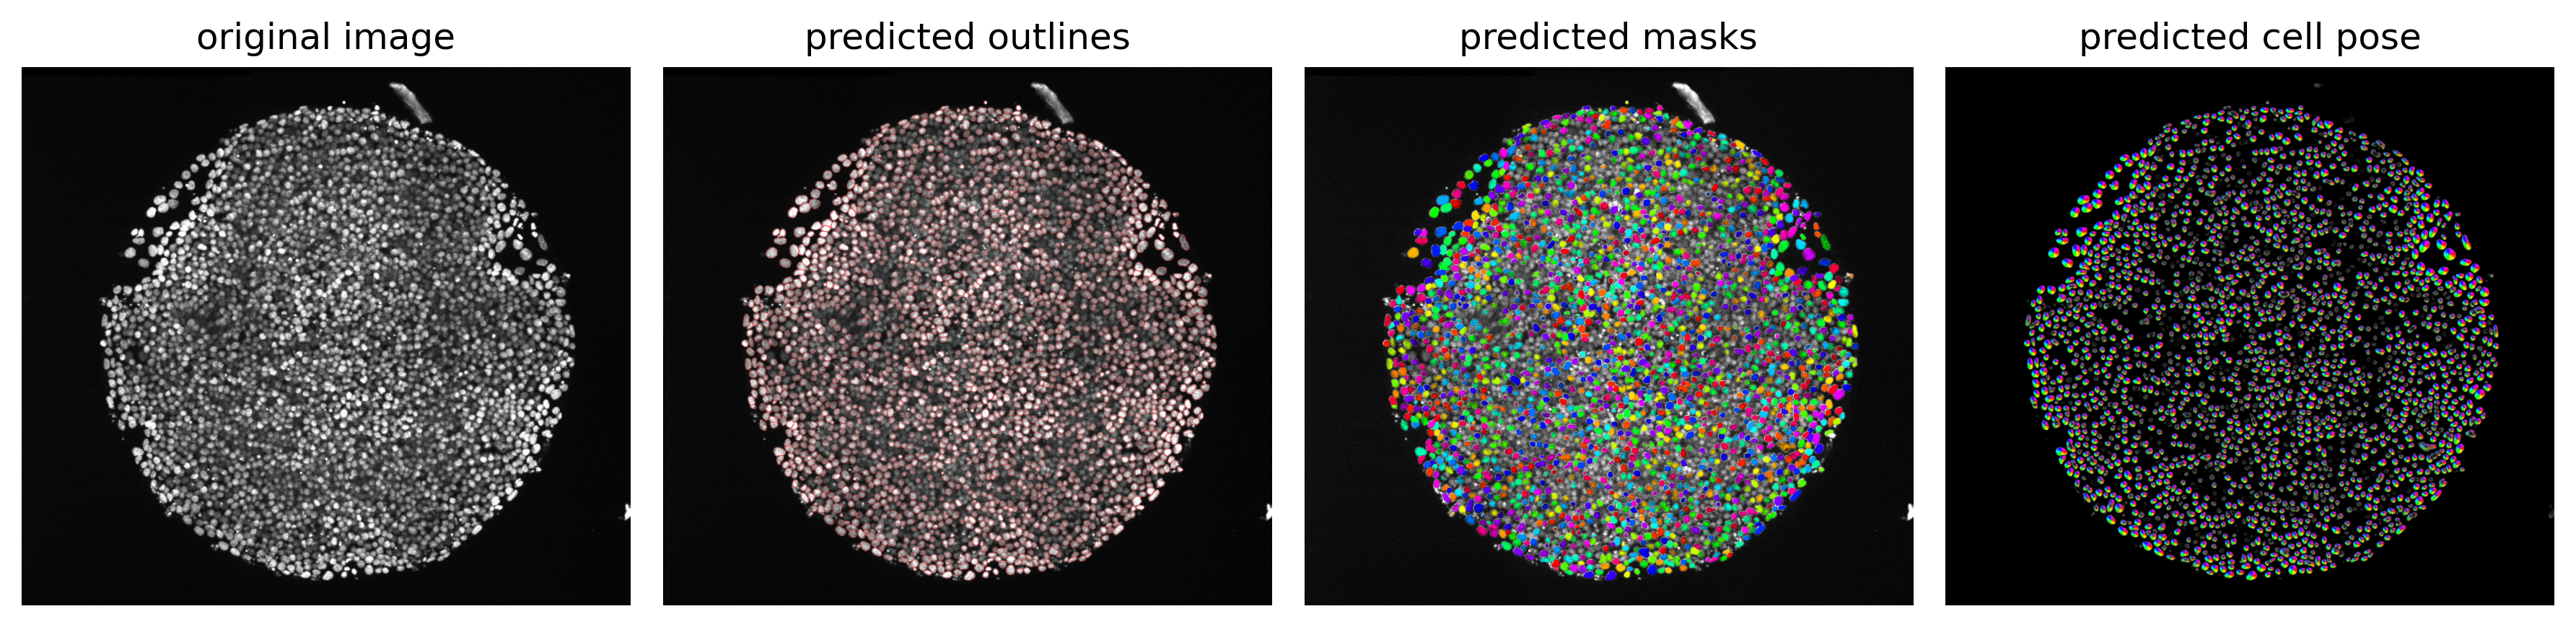

In [6]:
# DISPLAY RESULTS
#The built-in way of doing this is extremely slow, I've been saving results and visualizing in matlab instead
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, J, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

In [7]:
# RUN CELLPOSE

#from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='nuclei')
chan = [0,0]

#base = os.path.splitext(filename)[0]

# or in a loop
#for chan, filename in zip(channels, files):
for filename in files:
    base = os.path.splitext(filename)[0]
    print(base)
    img = io.imread(filename)
    nzslices = img.shape[0]
    for zi in range(0,nzslices):
        im = img[zi,:,:]
        p1, p99 = np.percentile(im, (1, 99))
        J = exposure.rescale_intensity(im, in_range=(p1, p99))
        masks, flows, styles, diams = model.eval(J, diameter=20, channels=chan, net_avg=True)
        # save results as png
        masks = masks.astype(np.uint16) if masks.max()<2**16-1 else masks.astype(np.uint32)
        io.imsave(base + '_z000' + str(zi) + '_cp_masks.png', masks)

2022-07-19 16:34:11,561 [INFO] ** TORCH CUDA version installed and working. **
2022-07-19 16:34:11,561 [INFO] >>>> using GPU
Y:\Seth\220712_Smad4GFP_BMP_IWP2_MP_live\fixed_round1\stitched_p0000_w0000_t0000
2022-07-19 16:34:12,559 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:34:15,962 [INFO] >>>> TOTAL TIME 3.40 sec
2022-07-19 16:34:16,064 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:34:19,895 [INFO] >>>> TOTAL TIME 3.83 sec
2022-07-19 16:34:19,999 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:34:24,065 [INFO] >>>> TOTAL TIME 4.07 sec
2022-07-19 16:34:24,192 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:34:28,514 [INFO] >>>> TOTAL TIME 4.32 sec
2022-07-19 16:34:28,643 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:34:32,561 [INFO] >>>> TOTAL TIME 3.92 sec
2022-07-19 16:34:32,660 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:34:35,889 [INFO] >>>> TOTAL TIME 3.23 sec
2022-07-19 16:34:35,969 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:34:39,171 [INFO] >>>> TOTAL TIME 3.20 sec
2022-07-19 16:34:39,277 [INFO] 

2022-07-19 16:38:19,287 [INFO] >>>> TOTAL TIME 3.52 sec
2022-07-19 16:38:19,388 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:38:22,773 [INFO] >>>> TOTAL TIME 3.39 sec
2022-07-19 16:38:22,884 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:38:25,905 [INFO] >>>> TOTAL TIME 3.02 sec
2022-07-19 16:38:26,005 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:38:28,975 [INFO] >>>> TOTAL TIME 2.97 sec
Y:\Seth\220712_Smad4GFP_BMP_IWP2_MP_live\fixed_round1\stitched_p0008_w0000_t0000
2022-07-19 16:38:29,734 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:38:32,951 [INFO] >>>> TOTAL TIME 3.22 sec
2022-07-19 16:38:33,036 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:38:36,673 [INFO] >>>> TOTAL TIME 3.64 sec
2022-07-19 16:38:36,777 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:38:40,269 [INFO] >>>> TOTAL TIME 3.49 sec
2022-07-19 16:38:40,378 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:38:44,097 [INFO] >>>> TOTAL TIME 3.72 sec
2022-07-19 16:38:44,177 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:38:47,913 [INFO] >>>> TOTAL TIME 

2022-07-19 16:42:22,398 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:42:26,283 [INFO] >>>> TOTAL TIME 3.89 sec
2022-07-19 16:42:26,376 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:42:29,854 [INFO] >>>> TOTAL TIME 3.48 sec
2022-07-19 16:42:29,974 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:42:33,368 [INFO] >>>> TOTAL TIME 3.39 sec
2022-07-19 16:42:33,448 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:42:36,567 [INFO] >>>> TOTAL TIME 3.12 sec
2022-07-19 16:42:36,662 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:42:39,568 [INFO] >>>> TOTAL TIME 2.91 sec
2022-07-19 16:42:39,640 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:42:42,260 [INFO] >>>> TOTAL TIME 2.62 sec
Y:\Seth\220712_Smad4GFP_BMP_IWP2_MP_live\fixed_round1\stitched_p0016_w0000_t0000
2022-07-19 16:42:43,000 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:42:46,186 [INFO] >>>> TOTAL TIME 3.19 sec
2022-07-19 16:42:46,264 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 16:42:49,832 [INFO] >>>> TOTAL TIME 3.57 sec
2022-07-19 16:42:49,959 [INFO] ~~~ FINDING MASK

In [9]:
#do_3D=False, anisotropy=None
# RUN CELLPOSE

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=True, model_type='nuclei')
chan = [0,0]

for filename in files:
    base = os.path.splitext(filename)[0]
    print(base)
    img = io.imread(filename)
    p1, p99 = np.percentile(img, (1, 99))
    J = exposure.rescale_intensity(img, in_range=(p1, p99))
    masks, flows, styles, diams = model.eval(J, diameter=35, channels=chan, net_avg=True, z_axis=0, do_3D=False, anisotropy=None)
    masks = masks.astype(np.uint16) if masks.max()<2**16-1 else masks.astype(np.uint32)
    io.imsave(base + '_cp_masks.tif', masks)

2022-07-19 13:57:36,207 [INFO] ** TORCH CUDA version installed and working. **
2022-07-19 13:57:36,207 [INFO] >>>> using GPU
Y:\Seth\220708_Smad4GFP_H2B_Smad4_BMP_IWP2_MP_live\fixed_round1\stitched_p0000_w0000_t0000
2022-07-19 13:57:42,487 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 13:57:48,352 [INFO] >>>> TOTAL TIME 5.86 sec
Y:\Seth\220708_Smad4GFP_H2B_Smad4_BMP_IWP2_MP_live\fixed_round1\stitched_p0001_w0000_t0000
2022-07-19 13:57:54,655 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 13:58:00,736 [INFO] >>>> TOTAL TIME 6.08 sec
Y:\Seth\220708_Smad4GFP_H2B_Smad4_BMP_IWP2_MP_live\fixed_round1\stitched_p0002_w0000_t0000
2022-07-19 13:58:07,158 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 13:58:13,049 [INFO] >>>> TOTAL TIME 5.89 sec
Y:\Seth\220708_Smad4GFP_H2B_Smad4_BMP_IWP2_MP_live\fixed_round1\stitched_p0003_w0000_t0000
2022-07-19 13:58:19,473 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 13:58:25,595 [INFO] >>>> TOTAL TIME 6.12 sec
Y:\Seth\220708_Smad4GFP_H2B_Smad4_BMP_IWP2_MP_live\fixed_round1\stitched_p0

In [13]:
base = os.path.splitext(filename)[0]
print(base)
img = io.imread(filename)
p1, p99 = np.percentile(img, (1, 99))
J = exposure.rescale_intensity(img, in_range=(p1, p99))
masks, flows, styles, diams = model.eval(J, diameter=35, channels=chan, net_avg=True, z_axis=0, do_3D=False, anisotropy=None)
masks = masks.astype(np.uint16) if masks.max()<2**16-1 else masks.astype(np.uint32)

masks.shape

Y:\Seth\220708_Smad4GFP_H2B_Smad4_BMP_IWP2_MP_live\fixed_round1\stitched_p0015_w0000_t0000
2022-07-19 14:02:19,376 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 14:02:25,126 [INFO] >>>> TOTAL TIME 5.75 sec


(2703, 2703)

In [15]:
masks, flows, styles, diams = model.eval(J, diameter=35, channels=chan, net_avg=True, z_axis=0, do_3D=False, anisotropy=None)
print(J.shape)
print(masks.shape)

2022-07-19 14:03:15,860 [INFO] ~~~ FINDING MASKS ~~~
2022-07-19 14:03:21,626 [INFO] >>>> TOTAL TIME 5.77 sec
(8, 2703, 2703)
(2703, 2703)


In [21]:
chan = [0,0]
p1, p99 = np.percentile(img, (1, 99))
J = exposure.rescale_intensity(img, in_range=(p1, p99))
masks, flows, styles, diams = model.eval(J, channels=chan, z_axis=0, diameter=35, do_3D=True, anisotropy=8, net_avg=True, min_size=15)


2021-09-20 11:32:59,079 [INFO] ~~~ FINDING MASKS ~~~
2021-09-20 11:32:59,080 [INFO] multi-stack tiff read in as having 5 planes 1 channels
2021-09-20 11:33:00,906 [INFO] running YX: 5 planes of size (3635, 3635)
2021-09-20 11:33:15,766 [INFO] 100%|##########| 5/5 [00:03<00:00,  1.43it/s]
2021-09-20 11:33:17,366 [INFO] running ZY: 3635 planes of size (5, 3635)
2021-09-20 11:36:57,913 [INFO] 100%|##########| 1212/1212 [00:54<00:00, 22.43it/s]
2021-09-20 11:37:03,394 [INFO] running ZX: 3635 planes of size (5, 3635)
2021-09-20 11:40:42,920 [INFO] 100%|##########| 1212/1212 [00:53<00:00, 22.60it/s]
2021-09-20 11:40:49,709 [INFO] network run in 470.33s
2021-09-20 11:42:34,119 [INFO] masks created in 104.41s
2021-09-20 11:42:41,087 [INFO] >>>> TOTAL TIME 582.01 sec


In [22]:
filename = files[0]
base = os.path.splitext(filename)[0]
masks = masks.astype(np.uint16) if masks.max()<2**16-1 else masks.astype(np.uint32)
io.imsave(base + '_rescaled_multiZ_cp_masks.tif', masks)

In [18]:
base + '_multiZ_cp_masks.png'

'Y:\\Seth\\210827_Smad4GFP_BMP_IWP2_live\\fixed\\stitched_p0000_w0000_t0000_multiZ_cp_masks.png'